# Part 1 – NONDERIV_TRANS.tsv Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the **NONDERIV_TRANS.tsv** file. We focus on:
- Basic structure and missing values
- Filtering to **COMMON stock** and **P/S (Buy/Sell)** transactions
- Distribution of transaction codes
- Transaction dates and time trends
- Shares, price per share, and dollar-value distributions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Load data
We load only the relevant columns used in the analysis. That is: 

| **Field Name**        | **Description**                                                                                               | **Data Type**       | **Nullable** | **Key** |
|------------------------|---------------------------------------------------------------------------------------------------------------|---------------------|---------------|----------|
| SECURITY_TITLE         | Security title                                                                                                | VARCHAR2 (60)       | No            |          |
| TRANS_DATE             | Transaction date in (DD-MON-YYYY) format.                                                                     | DATE                | No            |          |
| TRANS_SHARES           | Transaction shares reported when Securities Acquired (A) or Disposed of (D).                                  | NUMBER(16,2)        | Yes           |          |
| TRANS_PRICEPERSHARE    | Price of non-Derivative Transaction Security.                                                                 | NUMBER(16,2)        | Yes           |          |
| TRANS_CODE             | Transaction code (values and descriptions are listed in the Appendix section 6.2 Trans Code List).            | VARCHAR2 (1)        | Yes           |          |


If the file path is different on your system, update `NONDERIV_PATH` accordingly.

In [3]:
NONDERIV_PATH = r"/Users/aaniaadap/Desktop/KDDM Project/Dataset/NONDERIV_TRANS.tsv"  # <-- update this

nonderiv_cols = ['SECURITY_TITLE', 'TRANS_DATE', 'TRANS_SHARES',
                 'TRANS_PRICEPERSHARE', 'TRANS_CODE']

df_nonderiv = pd.read_csv(NONDERIV_PATH, sep='\t', usecols=nonderiv_cols, low_memory=False)
df_nonderiv.head()

,SECURITY_TITLE,TRANS_DATE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE
0,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
1,"Non-Voting Ordinary Shares, No Par Value",31-MAR-2025,J,1185242.00,3.01
2,2024 Annual Restricted Stock Units,27-MAR-2025,A,13.24,NaN
3,2024 Annual Restricted Stock Units,27-MAR-2025,A,21.47,NaN
4,2024 Elective Restricted Stock Units,27-MAR-2025,A,5.88,NaN


## Basic information and missing values
We check the **shape**, **data types**, and **missing values** to understand data quality before applying any filters.

In [4]:
print('Shape:', df_nonderiv.shape)
df_nonderiv.dtypes

Shape: (103029, 5)


SECURITY_TITLE          object
TRANS_DATE              object
TRANS_CODE              object
TRANS_SHARES           float64
TRANS_PRICEPERSHARE    float64
dtype: object

In [5]:
missing = df_nonderiv.isnull().sum()
missing_pct = (missing / len(df_nonderiv) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df

,Missing Count,Missing %
SECURITY_TITLE,0,0.00
TRANS_DATE,0,0.00
TRANS_CODE,1,0.00
TRANS_SHARES,0,0.00
TRANS_PRICEPERSHARE,7714,7.49


## Filter for COMMON stock and P/S transactions
We restrict the dataset to:
- Rows where `SECURITY_TITLE` contains **'COMMON'** (case-insensitive), and
- `TRANS_CODE` is either **'P' (Purchase)** or **'S' (Sale)**.

This focuses the analysis on standard insider buy/sell transactions in common stock.

In [6]:
df_filtered = df_nonderiv[
    df_nonderiv['SECURITY_TITLE'].str.contains('COMMON', case=False, na=False)
    & df_nonderiv['TRANS_CODE'].isin(['P', 'S'])
].copy()

print('Records after filtering:', len(df_filtered))
print('Percentage retained:', round(len(df_filtered) / len(df_nonderiv) * 100, 2), '%')

df_filtered['TRANS_CODE'].value_counts()

Records after filtering: 26190
Percentage retained: 25.42 %


TRANS_CODE
S    20798
P     5392
Name: count, dtype: int64

## 4. Transaction date analysis
We convert `TRANS_DATE` to datetime and derive **year** and **year-month** fields to study temporal patterns.

In [7]:
df_filtered['TRANS_DATE'] = pd.to_datetime(df_filtered['TRANS_DATE'], errors='coerce')
df_filtered['year'] = df_filtered['TRANS_DATE'].dt.year
df_filtered['year_month'] = df_filtered['TRANS_DATE'].dt.to_period('M')

print('Date range:', df_filtered['TRANS_DATE'].min(), 'to', df_filtered['TRANS_DATE'].max())

transactions_by_year = df_filtered['year'].value_counts().sort_index()
transactions_by_year

Date range: 2011-07-26 00:00:00 to 2025-10-24 00:00:00


year
2011        1
2012       29
2014        1
2015        1
2016        1
2017        1
2020        3
2021        9
2022       32
2023       58
2024      991
2025    25063
Name: count, dtype: int64

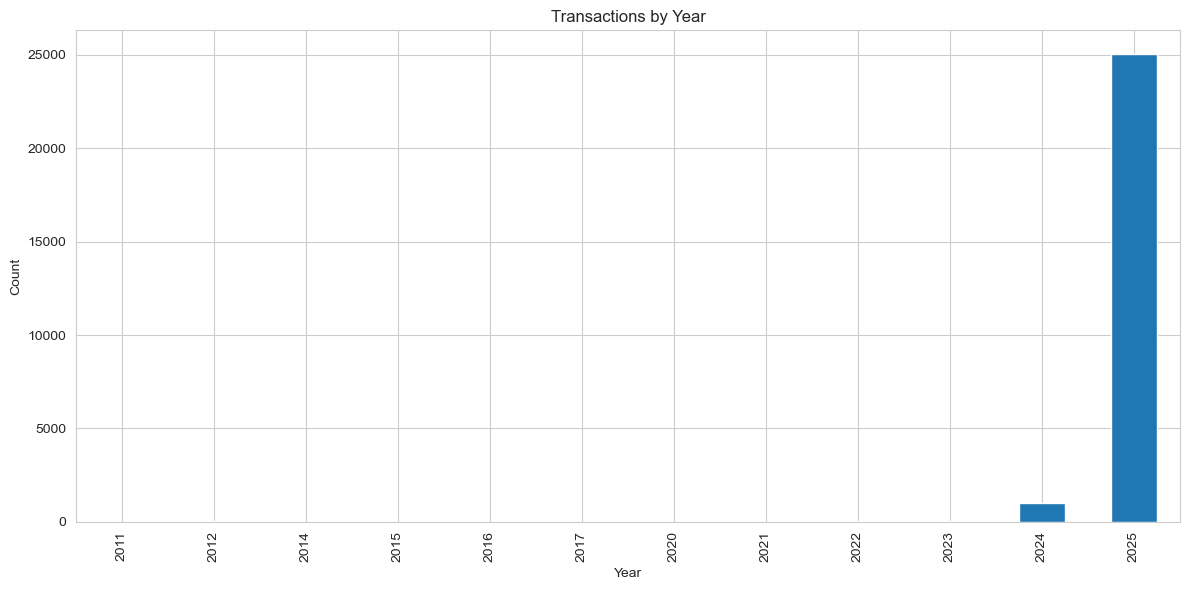

In [8]:
plt.figure()
df_filtered['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Transactions by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. Shares, price per share, and dollar value
We examine the distributions of:
- `TRANS_SHARES`
- `TRANS_PRICEPERSHARE`
- `dollar_value = TRANS_SHARES × TRANS_PRICEPERSHARE`
including summary statistics and selected percentiles.

In [9]:
numeric_cols = ['TRANS_SHARES', 'TRANS_PRICEPERSHARE']
for col in numeric_cols:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

df_filtered['dollar_value'] = df_filtered['TRANS_SHARES'] * df_filtered['TRANS_PRICEPERSHARE']

stats = df_filtered[['TRANS_SHARES', 'TRANS_PRICEPERSHARE', 'dollar_value']].describe()
stats

,TRANS_SHARES,TRANS_PRICEPERSHARE,dollar_value
count,2.619000e+04,26149.000000,2.614900e+04
mean,7.813268e+04,239.322384,1.809489e+06
std,1.608907e+06,7266.819337,2.957734e+07
min,0.000000e+00,0.000000,0.000000e+00
25%,5.130000e+02,13.220000,2.512362e+04
50%,2.317500e+03,54.000000,1.368466e+05
75%,1.000575e+04,190.550000,5.453051e+05
max,1.946288e+08,878401.000000,2.740968e+09


In [10]:
percentiles = [10, 25, 50, 75, 90, 95, 99]
dv = df_filtered['dollar_value'].dropna()

pd.DataFrame({f'{p}th': [dv.quantile(p/100)] for p in percentiles})

,10th,25th,50th,75th,90th,95th,99th
0,3002.5008,25123.62,136846.6,545305.12,1826420.342,3832182.36,1.700894e+07


## 6. Visualizations
Below we plot:
- Buy vs Sell transaction counts
- Distribution of dollar values (log scale to handle skew)
These plots help visually confirm patterns seen in the summary statistics.

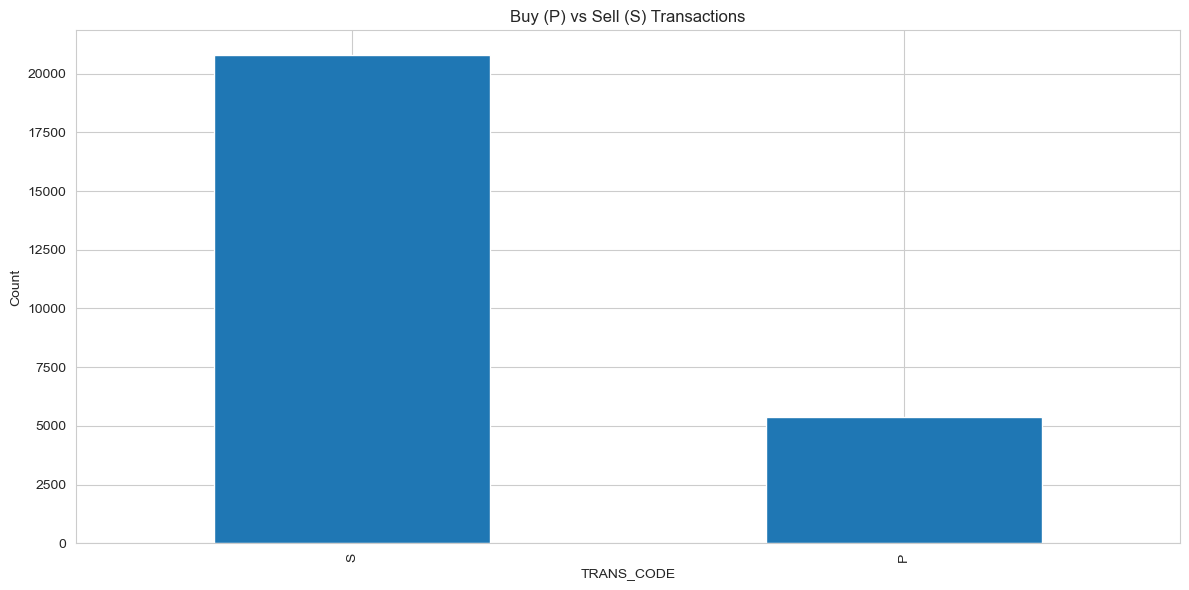

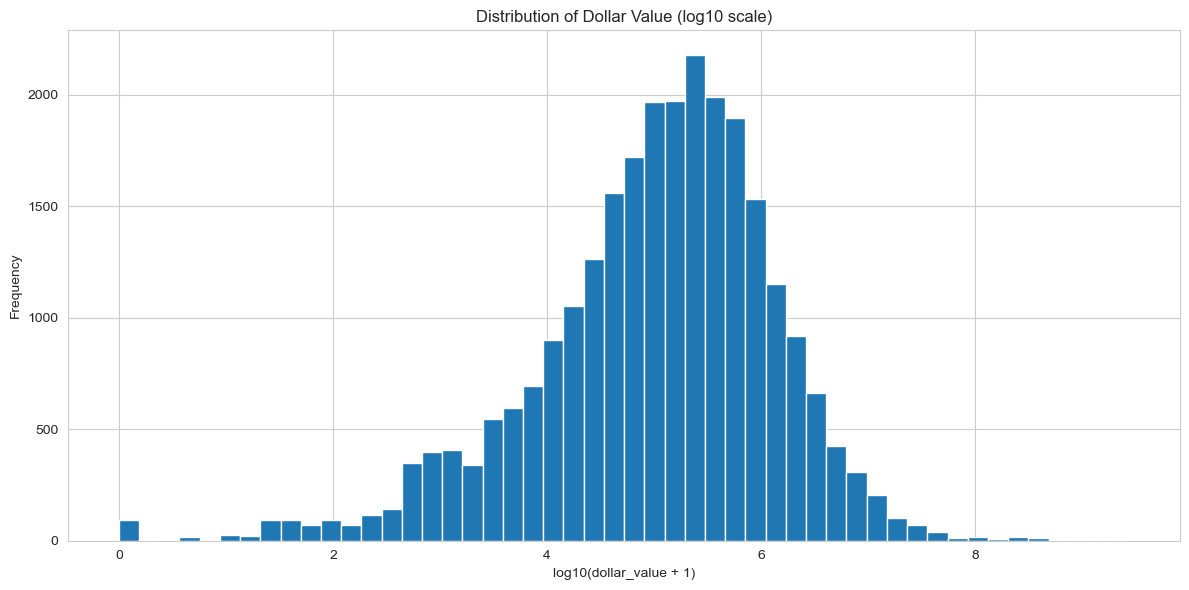

In [11]:
plt.figure()
df_filtered['TRANS_CODE'].value_counts().plot(kind='bar')
plt.title('Buy (P) vs Sell (S) Transactions')
plt.xlabel('TRANS_CODE')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
dv_log = np.log10(df_filtered['dollar_value'].dropna() + 1)
dv_log.plot(kind='hist', bins=50)
plt.title('Distribution of Dollar Value (log10 scale)')
plt.xlabel('log10(dollar_value + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##  Monthly trends: counts, dollar value, buy/sell ratio

In [12]:
# Aggregate by month
monthly = (
    df_filtered
    .groupby('year_month')
    .agg(
        n_trades=('TRANS_CODE', 'count'),
        total_dollar_value=('dollar_value', 'sum'),
        buys=('TRANS_CODE', lambda x: (x == 'P').sum()),
        sells=('TRANS_CODE', lambda x: (x == 'S').sum())
    )
)

monthly['buy_sell_ratio'] = monthly['buys'] / monthly['sells'].replace(0, np.nan)

monthly.tail()


,n_trades,total_dollar_value,buys,sells,buy_sell_ratio
year_month,,,,,
2024-12,439,5.488109e+08,183,256,0.714844
2025-01,6735,7.852121e+09,1078,5657,0.190560
2025-02,9098,2.151575e+10,1630,7468,0.218265
2025-03,9228,1.712910e+10,2025,7203,0.281133
2025-10,2,4.637902e+03,2,0,NaN


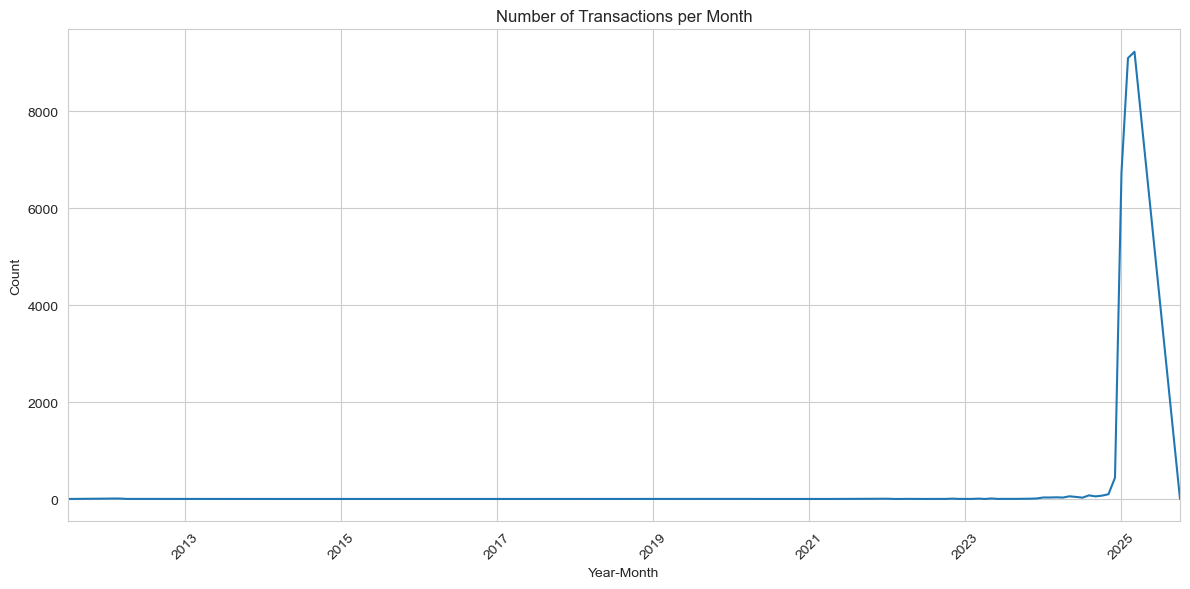

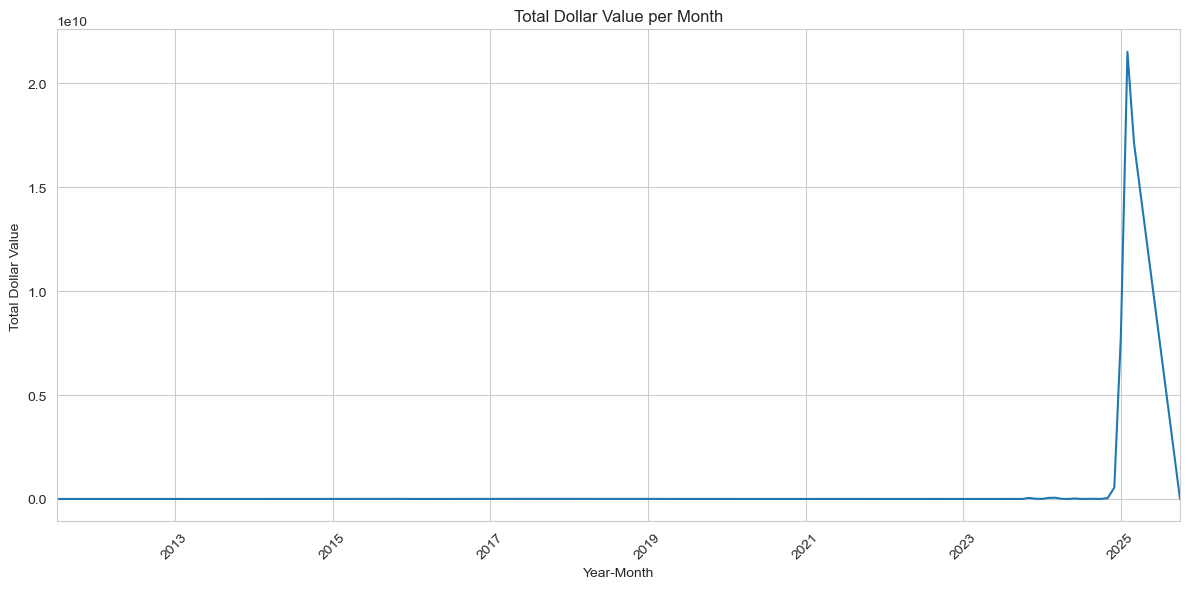

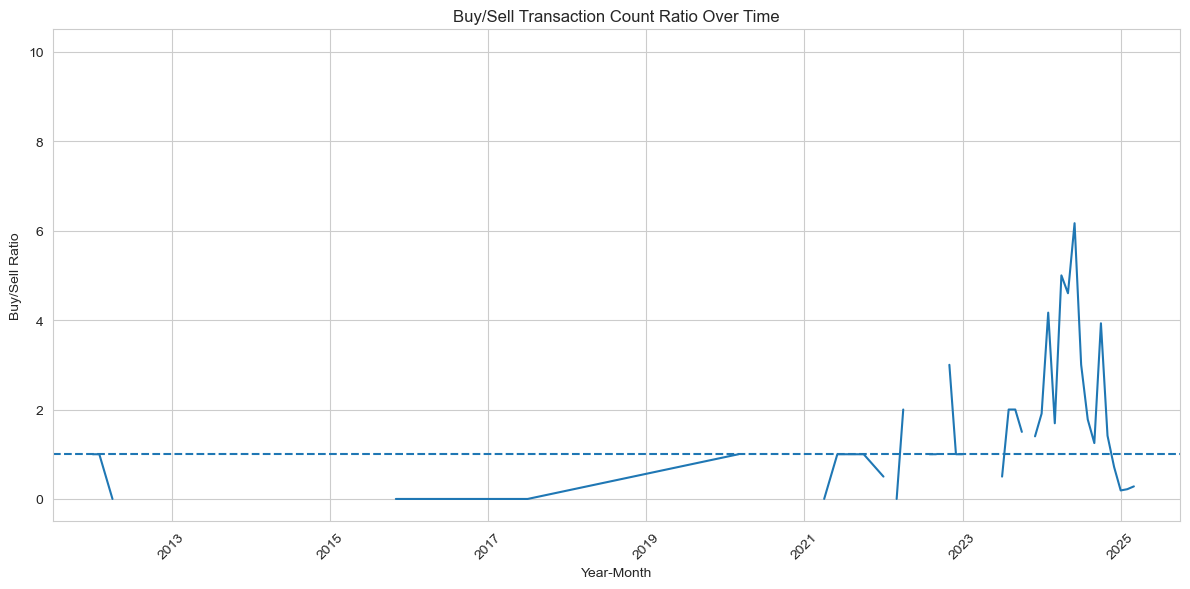

In [13]:
# Plot: trades per month
plt.figure()
monthly['n_trades'].plot()
plt.title('Number of Transactions per Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: total dollar value per month
plt.figure()
monthly['total_dollar_value'].plot()
plt.title('Total Dollar Value per Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Dollar Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: buy/sell ratio over time
plt.figure()
monthly['buy_sell_ratio'].plot()
plt.title('Buy/Sell Transaction Count Ratio Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Buy/Sell Ratio')
plt.xticks(rotation=45)
plt.axhline(1, linestyle='--')
plt.tight_layout()
plt.show()


Here we analyse when insiders are more net-buy vs net-sell and how intensity changes over time

## Compare buy vs sell behaviour (size, price, dollar value)

In [15]:
buy_sell_summary = (
    df_filtered
    .groupby('TRANS_CODE')
    .agg(
        n_trades=('dollar_value', 'count'),
        median_dollar_value=('dollar_value', 'median'),
        mean_dollar_value=('dollar_value', 'mean'),
        median_shares=('TRANS_SHARES', 'median'),
        mean_shares=('TRANS_SHARES', 'mean'),
        median_price=('TRANS_PRICEPERSHARE', 'median'),
        mean_price=('TRANS_PRICEPERSHARE', 'mean')
    )
)

buy_sell_summary


,n_trades,median_dollar_value,mean_dollar_value,median_shares,mean_shares,median_price,mean_price
TRANS_CODE,,,,,,,
P,5364,18357.114,1.389613e+06,1855.0,89992.366786,11.31,108.210429
S,20785,192309.960,1.917847e+06,2411.0,75057.994433,78.44,273.158541


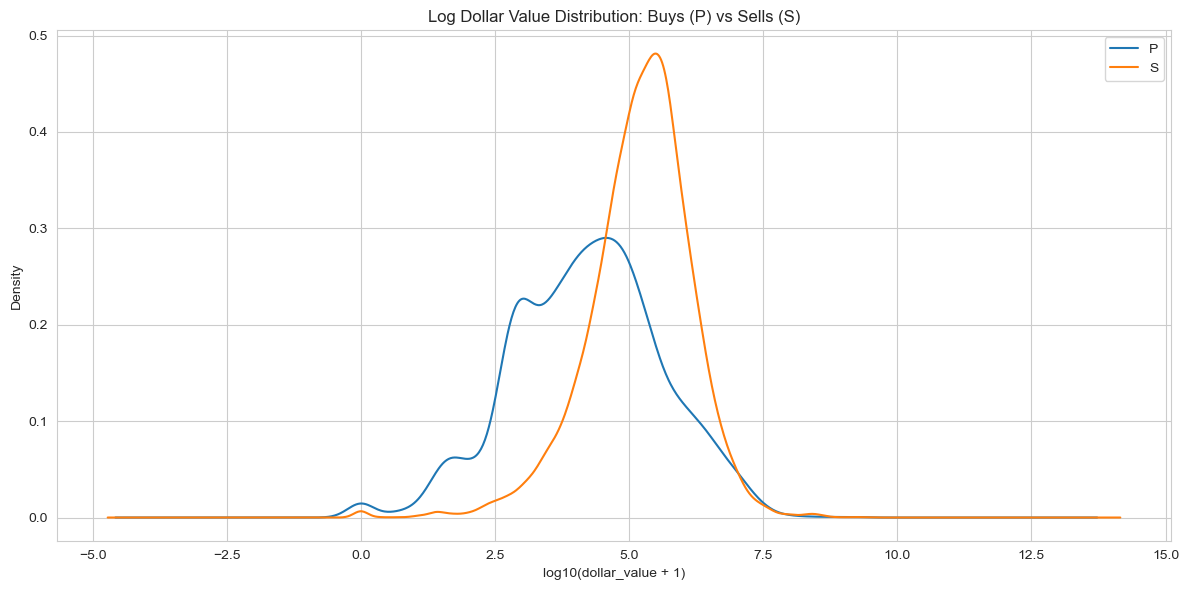

In [16]:
# Visual: distribution of log-dollar value by P vs S
plt.figure()
for code in ['P', 'S']:
    subset = np.log10(df_filtered.loc[df_filtered['TRANS_CODE'] == code, 'dollar_value'] + 1)
    subset.plot(kind='kde', label=code)
plt.title('Log Dollar Value Distribution: Buys (P) vs Sells (S)')
plt.xlabel('log10(dollar_value + 1)')
plt.legend()
plt.tight_layout()
plt.show()


Checking if sells are larger than buys, if buys happen at lower/higher prices, etc.

## Flag and inspect large / extreme trades (outliers)

In [17]:
# Define threshold as 99th percentile of dollar_value
threshold_99 = df_filtered['dollar_value'].quantile(0.99)

large_trades = df_filtered[df_filtered['dollar_value'] >= threshold_99].copy()
large_trades_sorted = large_trades.sort_values('dollar_value', ascending=False)

threshold_99, large_trades_sorted.head(20)


(17008944.223600008,
                                   SECURITY_TITLE TRANS_DATE TRANS_CODE  \
 38843    Common Stock, par value $0.01 per share 2025-02-26          S   
 47028                               Common Stock 2025-02-24          S   
 17381                       Class A Common Stock 2025-03-12          S   
 17344                       Class A Common Stock 2025-03-12          S   
 40656                       Class A Common Stock 2025-02-26          P   
 40655                       Class A Common Stock 2025-02-27          P   
 369                                 Common Stock 2025-03-27          S   
 2686                        Class A Common Stock 2025-03-24          S   
 13836                                     Common 2025-03-14          S   
 25113                       Class A Common Stock 2025-03-04          S   
 26360                       Class A Common Stock 2025-03-04          S   
 43804                               Common Stock 2025-02-24          S   
 847

In [18]:
# How many large trades are buys vs sells?
large_trades['TRANS_CODE'].value_counts(normalize=True)


TRANS_CODE
S    0.812977
P    0.187023
Name: proportion, dtype: float64

## Security-level view: which securities see most insider activity?

In [19]:
group_cols = []
if 'ISSUER_CIK' in df_filtered.columns:
    group_cols.append('ISSUER_CIK')
if 'ISSUER_TRADING_SYMBOL' in df_filtered.columns:
    group_cols.append('ISSUER_TRADING_SYMBOL')

# Always include security title as a fallback
group_cols.append('SECURITY_TITLE')

security_activity = (
    df_filtered
    .groupby(group_cols)
    .agg(
        n_trades=('dollar_value', 'count'),
        total_dollar_value=('dollar_value', 'sum'),
        net_dollar_value=('dollar_value', lambda x: x[df_filtered.loc[x.index, 'TRANS_CODE'] == 'P'].sum()
                                              - x[df_filtered.loc[x.index, 'TRANS_CODE'] == 'S'].sum())
    )
    .sort_values('total_dollar_value', ascending=False)
)

security_activity.head(20)


,n_trades,total_dollar_value,net_dollar_value
SECURITY_TITLE,,,
Common Stock,14952,2.112855e+10,-1.728055e+10
Class A Common Stock,7368,1.579413e+10,-8.220208e+09
"Common Stock, par value $0.01 per share",179,3.467943e+09,-3.211471e+09
Common,89,1.120898e+09,-1.120148e+09
Common Shares,572,8.204334e+08,-6.497681e+08
"Class A Common Stock, par value $0.0001 per share",14,5.227019e+08,-5.227019e+08
Common Shares of Beneficial Interest,38,4.340425e+08,2.554550e+08
"Common Stock, no par value",41,3.922709e+08,-2.381214e+08
"Common Stock, $0.0001 par value per share",10,3.388406e+08,3.349598e+08


Shows which companies/securities attract the most insider trading and whether insiders are net buyers or sellers.

# Stability and anomaly: month-over-month changes

In [20]:
monthly_changes = monthly[['n_trades', 'total_dollar_value']].copy()
monthly_changes['n_trades_change_pct'] = monthly_changes['n_trades'].pct_change() * 100
monthly_changes['dollar_value_change_pct'] = monthly_changes['total_dollar_value'].pct_change() * 100

monthly_changes.tail()


,n_trades,total_dollar_value,n_trades_change_pct,dollar_value_change_pct
year_month,,,,
2024-12,439,5.488109e+08,343.434343,1187.294395
2025-01,6735,7.852121e+09,1434.168565,1330.751604
2025-02,9098,2.151575e+10,35.085375,174.011897
2025-03,9228,1.712910e+10,1.428885,-20.388054
2025-10,2,4.637902e+03,-99.978327,-99.999973


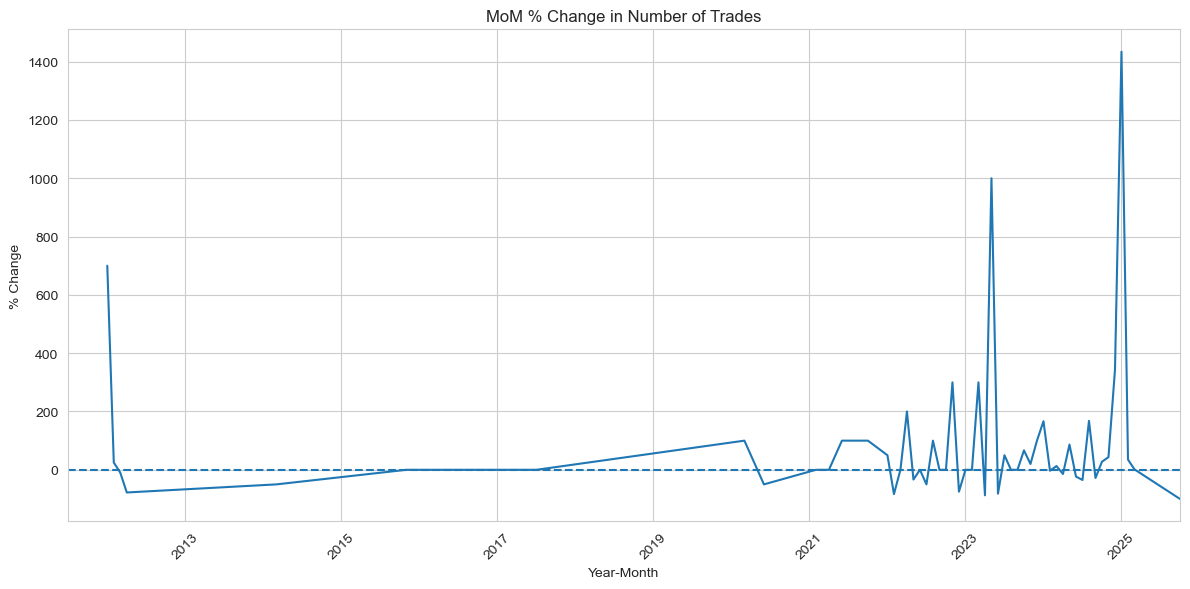

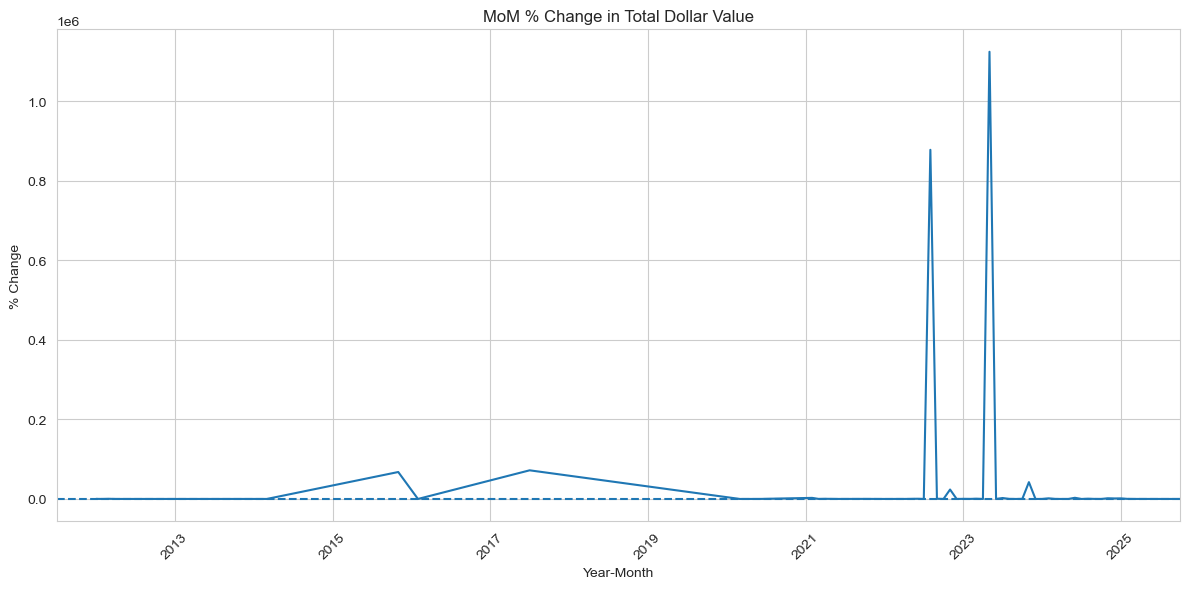

In [21]:
plt.figure()
monthly_changes['n_trades_change_pct'].plot()
plt.title('MoM % Change in Number of Trades')
plt.xlabel('Year-Month')
plt.ylabel('% Change')
plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
monthly_changes['dollar_value_change_pct'].plot()
plt.title('MoM % Change in Total Dollar Value')
plt.xlabel('Year-Month')
plt.ylabel('% Change')
plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Spikes here = months where insider activity is unusually high/low → candidate for deeper investigation.